In [1]:
#packages
import pandas as pd
import csv
import matplotlib as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import glob
import pycountry
from datetime import datetime

#chaning the number of columns that are displayed. get will tell you how much. 
pd.set_option("display.max_columns",50)
sns.set_style("darkgrid")

pd.options.mode.chained_assignment = None

# Section 1. BERT Data

Data range: 1st December 2017 - 10th July 2018

In [2]:
##### Cleaning

df_asl=pd.read_excel("lt_asl.xlsx")

#dropping columns
df_asl.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id","insert_time","update_time","revenue_type","currency",
                    "marketer_name","campaign_manager_name"], inplace=True)

#1. FIX MARGIN_P
def woo(x):
    if x["purchase"] == 0 and x["revenue"] >= 1:
        return(100)
    if x["purchase"] == 0 and x["revenue"] == 0:
        return(0)
    if x["purchase"] > 0 and x["revenue"] == 0:
        return(-100)
    else:
        return((x["margin"]/x["revenue"])*100)
df_asl["marginP"] = df_asl.apply(woo, axis=1)
df_asl["marginP"] = df_asl["marginP"].round(2)

### Top 20 ads (in margin) and their margin % 

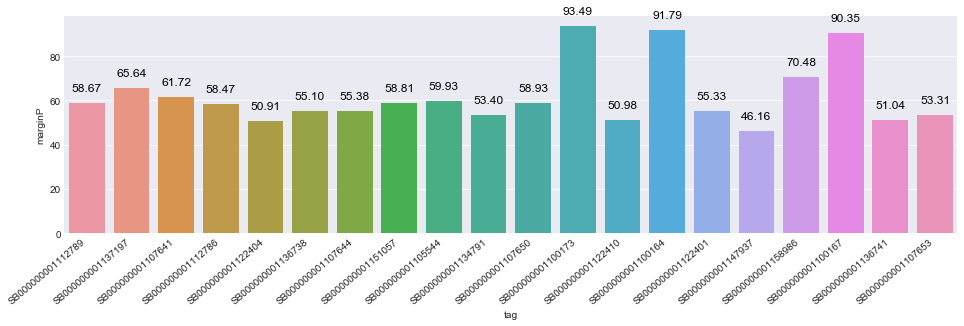

In [3]:
plt.pyplot.figure(figsize=(16,4))
ha=sns.barplot(x="tag", y="marginP", data=df_asl.nlargest(20,'margin'), capsize=.2, errwidth=.6)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
for p in ha.patches:
             ha.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha="center", va="center", fontsize=12, color="black", xytext=(0, 15),
                 textcoords="offset points")

____________

In [4]:
df_asl_camp=df_asl.groupby(by=["campaign_name"]).sum()
df_asl_camp["margin %"] = df_asl_camp.apply(woo, axis=1)
df_asl_camp["margin %"] = df_asl_camp["margin %"].round(2)

In [5]:
df_asl_camp["CTR"]=[7.5,1.7,1.9,1.8,1.5,2.5,1.9]
df_asl_camp["CPC"]=[0.09,0.35,0.36,0.33,0.37,0.24,0.47]
df_asl_camp["CPM"]=[7.10,5.98,6.89,5.97,9.49,4.55,6.96]
df_asl_camp["CR"]=[38.1,25.8,30.9,27.5,20.7,23.6,30.1]

### Campaign overview

In [6]:
df_asl_camp[["margin","margin %","views","clicks","CTR","CPC","CPM","CR"]]

,margin,margin %,views,clicks,CTR,CPC,CPM,CR
campaign_name,,,,,,,,
HelloFresh DE - Back-Quiz,4801.40,89.67,77882,5856,7.5,0.09,7.10,38.1
HelloFresh DE - Back-Quiz - HF Focus,3975.98,48.50,706164,12093,1.7,0.35,5.98,25.8
HelloFresh DE - Tester Gesucht,11989.25,58.83,1218183,23489,1.9,0.36,6.89,30.9
HelloFresh DE - Tester Gesucht V2,41982.50,57.50,5195189,93282,1.8,0.33,5.97,27.5
HelloFresh DE - Tester Gesucht V2 - Canvas,592.58,45.50,102016,1519,1.5,0.37,9.49,20.7
HelloFresh DE - Tester Gesucht V2 - Cities,332.22,36.66,60525,1534,2.5,0.24,4.55,23.6
HelloFresh DE - Tester gesucht V2 - B,1269.25,64.36,154533,2933,1.9,0.47,6.96,30.1


In [7]:
sheetnames=glob.glob("m_*.xlsx")
list_of_dfs = [pd.read_excel(sheet) for sheet in sheetnames]
for dataframe, sheet in zip(list_of_dfs, sheetnames):
    dataframe["mon_raw"] = sheet
df_monthly = pd.concat(list_of_dfs, ignore_index=True) 

df_monthly["marginP"] = df_monthly.apply(woo, axis=1)
df_monthly["marginP"] = df_monthly["marginP"].round(2)

df_monthly.drop(columns=["id","status","real_budget","start_date","end_date","url","ad_set_campaign_id",
                       "margin_percentage","facebook_ad_set_id","facebook_ad_account_id","facebook_business_id",
                       "short_url","ad_url_domain_id","insert_time","update_time","revenue_type","currency",
                    "marketer_name","campaign_manager_name"], inplace=True)

df_monthly["month"] = df_monthly["mon_raw"].str.split("_").str[1]
df_monthly.drop(columns=["mon_raw"], inplace=True)

order=["17 Dec","18 Jan","18 Feb","18 Mar","18 Apr","18 May","18 Jun"]

In [8]:
df_monthly['total']=1
df_monthly_total=df_monthly.groupby(by=['month']).sum()
df_monthly_total["margin_%"]=(df_monthly_total["margin"]/df_monthly_total["revenue"])*100
df_monthly_total["margin_%"]=df_monthly_total["margin_%"].round(2)
df_monthly_total["Month"]=df_monthly_total.index

_________________

### Total margin % over each month

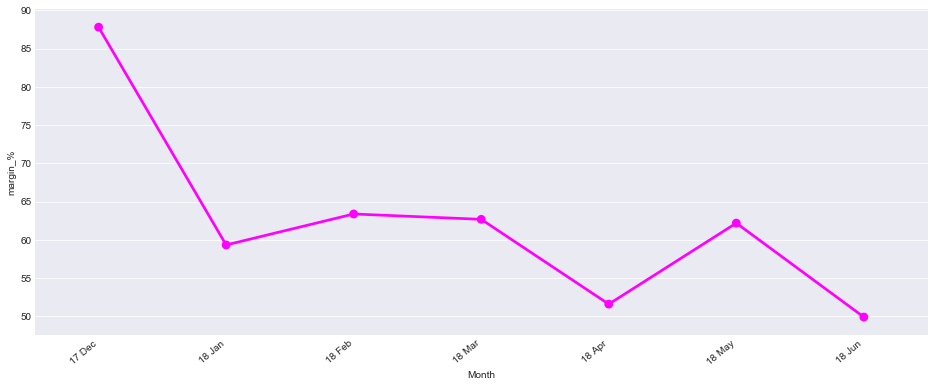

In [9]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.pointplot(x="Month", y="margin_%", color="magenta", errwidth=.5, data=df_monthly_total, order=order)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
ha

______________

### Total margin over each month

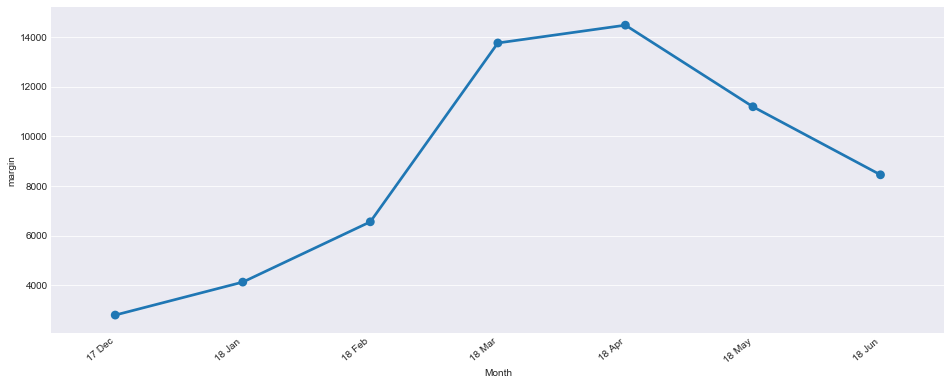

In [10]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.pointplot(x="Month", y="margin", errwidth=.5, data=df_monthly_total, order=order)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
ha

In [11]:
o1 = pd.read_excel("m_17 Dec_.xlsx")
o2 = pd.read_excel("m_18 Jan_.xlsx")
o3 = pd.read_excel("m_18 Feb_.xlsx")
o4 = pd.read_excel("m_18 Mar_.xlsx")
o5 = pd.read_excel("m_18 Apr_.xlsx")
o6 = pd.read_excel("m_18 May_.xlsx")
o7 = pd.read_excel("m_18 Jun_.xlsx")
o1 = o1.groupby(by=["campaign_name"]).sum()
o1["margin %"] = o1.apply(woo, axis=1)
o1["margin %"] = o1["margin %"].round(2)
o1["Month"] = "17 Dec"
o1["Campaign"] = o1.index
o2 = o2.groupby(by=["campaign_name"]).sum()
o2["margin %"] = o2.apply(woo, axis=1)
o2["margin %"] = o2["margin %"].round(2)
o2["Month"] = "18 Jan"
o2["Campaign"] = o2.index
o3 = o3.groupby(by=["campaign_name"]).sum()
o3["margin %"] = o3.apply(woo, axis=1)
o3["margin %"] = o3["margin %"].round(2)
o3["Month"] = "18 Feb"
o3["Campaign"] = o3.index
o4 = o4.groupby(by=["campaign_name"]).sum()
o4["margin %"] = o4.apply(woo, axis=1)
o4["margin %"] = o4["margin %"].round(2)
o4["Month"] = "18 Mar"
o4["Campaign"] = o4.index
o5 = o5.groupby(by=["campaign_name"]).sum()
o5["margin %"] = o5.apply(woo, axis=1)
o5["margin %"] = o5["margin %"].round(2)
o5["Month"] = "18 Apr"
o5["Campaign"] = o5.index
o6 = o6.groupby(by=["campaign_name"]).sum()
o6["margin %"] = o6.apply(woo, axis=1)
o6["margin %"] = o6["margin %"].round(2)
o6["Month"] = "18 May"
o6["Campaign"] = o6.index
o7 = o7.groupby(by=["campaign_name"]).sum()
o7["margin %"] = o7.apply(woo, axis=1)
o7["margin %"] = o7["margin %"].round(2)
o7["Month"] = "18 Jun"
o7["Campaign"] = o7.index

In [12]:
list_of_dfs=[o1,o2,o3,o4,o5,o6,o7]
df_mon = pd.concat(list_of_dfs, ignore_index=True)

___________

### Margins of campaigns over months

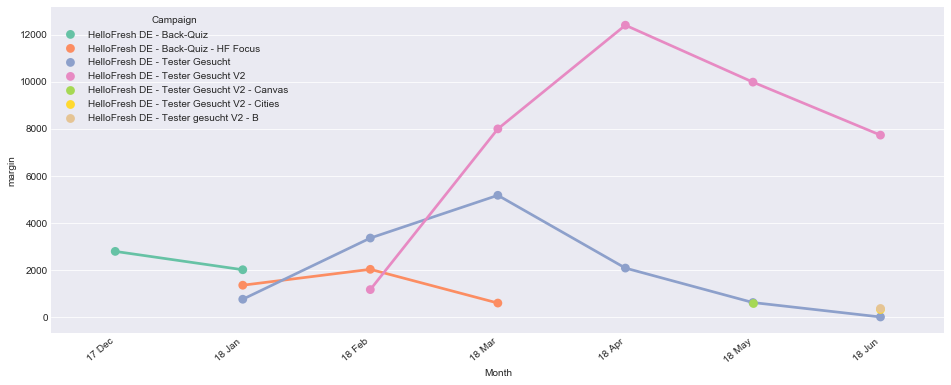

In [13]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.pointplot(x="Month", y="margin", hue="Campaign", palette="Set2", errwidth=.5, data=df_mon, order=order)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
ha

______________________

### Margin % of campaigns over months. 

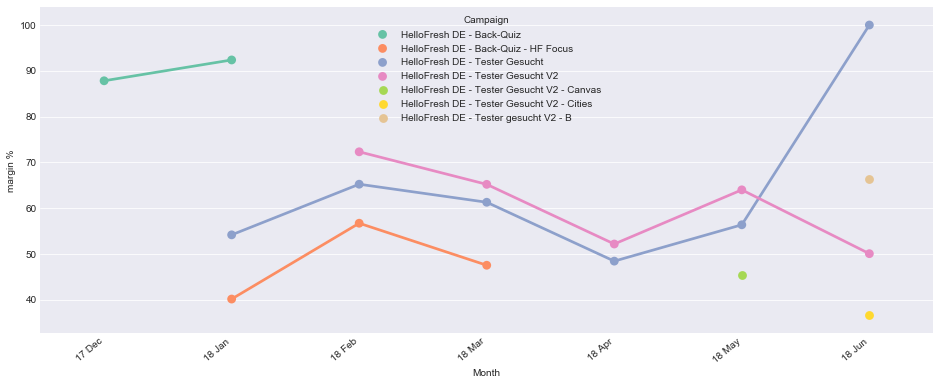

In [14]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.pointplot(x="Month", y="margin %", hue="Campaign", palette="Set2", errwidth=.5, data=df_mon, order=order)
ha.set_xticklabels(ha.get_xticklabels(), rotation=40, ha="right")
ha

____________

# Section 2. BM Data

In [15]:
tar = pd.read_csv("bm_target.csv")

In [16]:
tar["tag"] = tar['Ad set name'].str.split(',').str[0]

In [17]:
target = tar.loc[tar["Age"] != "All"]
target = target.loc[target["Gender"] != "All"]
target = target.loc[target["Gender"] != "unknown"]

In [18]:
girls = target.loc[target["Gender"]=="female"]
girls = girls.groupby(by=["Age"]).sum()
girls["Gender"] = "female"
girls["Age"] = girls.index
boys = target.loc[target["Gender"]=="male"]
boys = boys.groupby(by=["Age"]).sum()
boys["Gender"] = "male"
boys["Age"] = boys.index
tar_tot = pd.concat([girls, boys], ignore_index=True)

### Total Results over gender and age

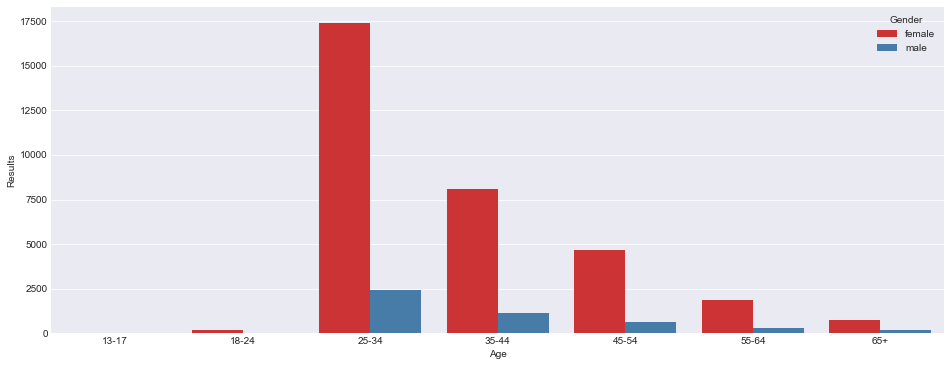

In [19]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="Results", hue="Gender",  palette="Set1", errwidth=.5, data=tar_tot)
ha

___________

### Amount spent over age and gender

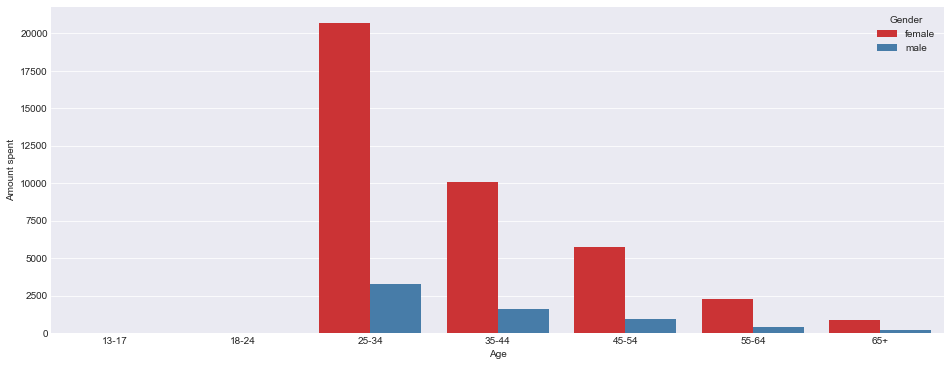

In [20]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="Amount spent", hue="Gender",  palette="Set1", errwidth=.5, data=tar_tot)
ha

______________

### Average CPA over age and gender

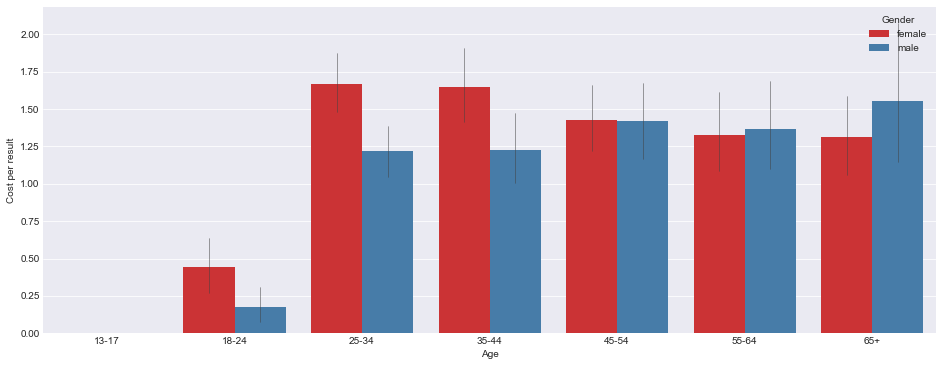

In [21]:
order=["13-17","18-24","25-34","35-44","45-54","55-64","65+"]
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="Cost per result", hue="Gender",  palette="Set1", errwidth=.5, data=target, order=order)
ha

__________

### Average CTR over age and gender

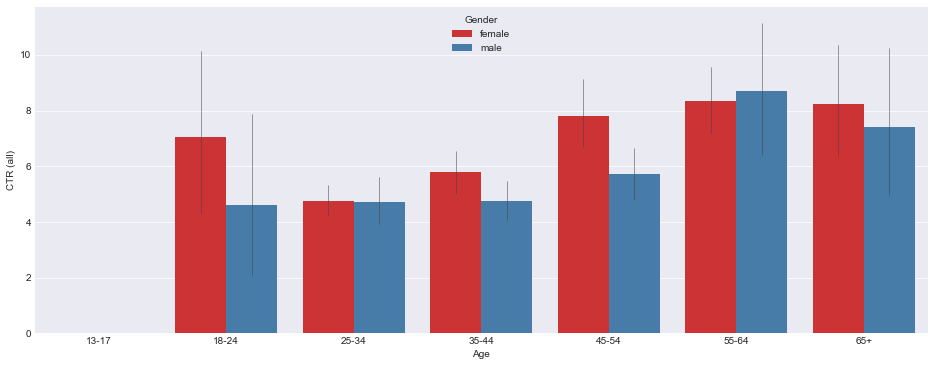

In [22]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="CTR (all)", hue="Gender", errwidth=.5, palette="Set1", data=target, order=order)
ha

______________

### Average CPM over age and gender

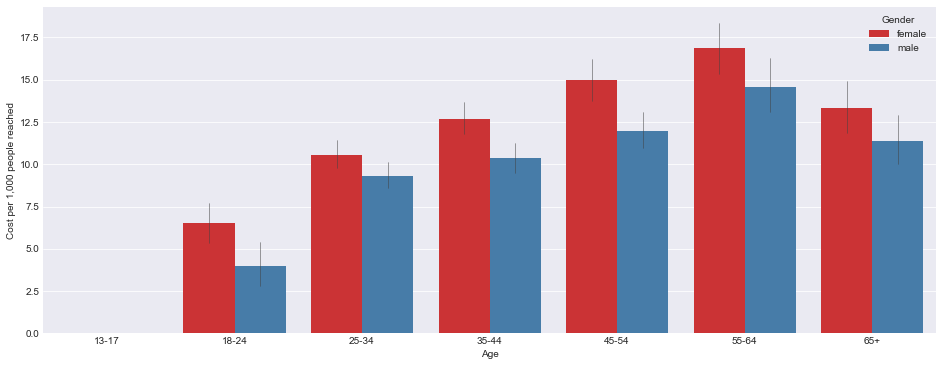

In [23]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="Cost per 1,000 people reached", hue="Gender", errwidth=.5, palette="Set1", data=target, order=order)
ha

________________

### Average frequency over gender and age

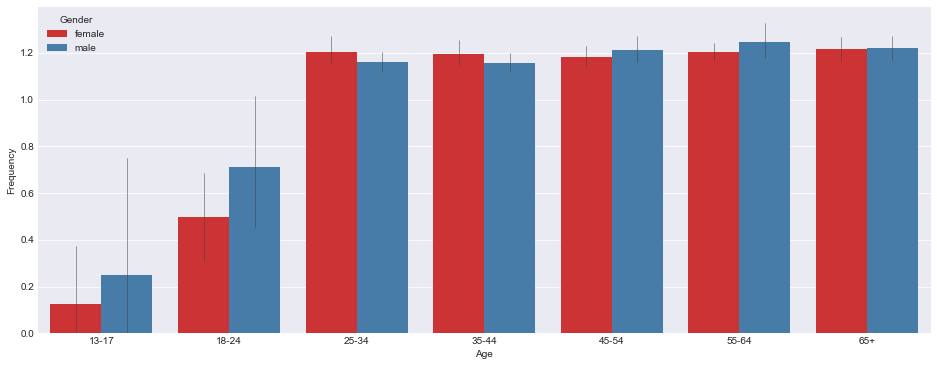

In [24]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Age", y="Frequency", hue="Gender", errwidth=.5, palette="Set1", data=target, order=order)
ha

______________

In [25]:
plac = pd.read_csv("bm_plac.csv")

In [26]:
plac = plac.loc[plac["Placement"]!="All"]

In [27]:
placement = plac.groupby(by=["Placement"]).sum()
placement["Placement"] = placement.index

### Results by placement

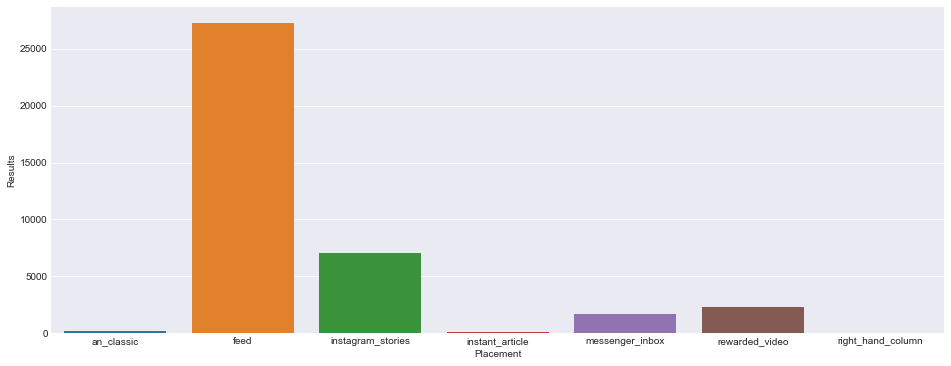

In [28]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="Results", errwidth=.5, data=placement)
ha

_______________

### Amount spent over placement

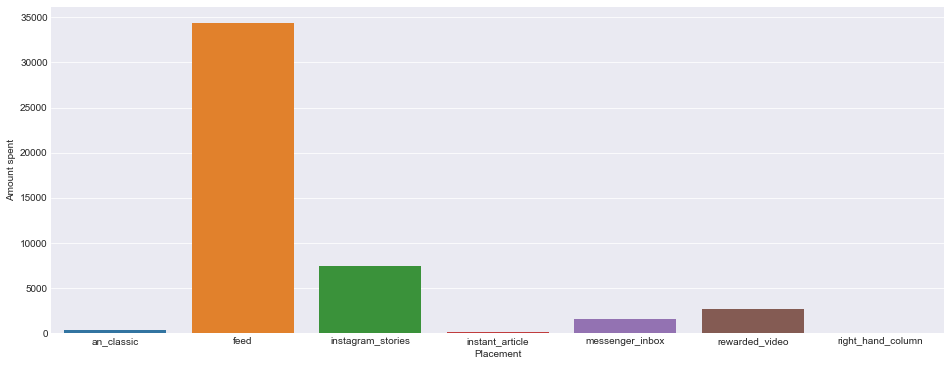

In [29]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="Amount spent", errwidth=.5, data=placement)
ha

____________

### Average CPA by placement

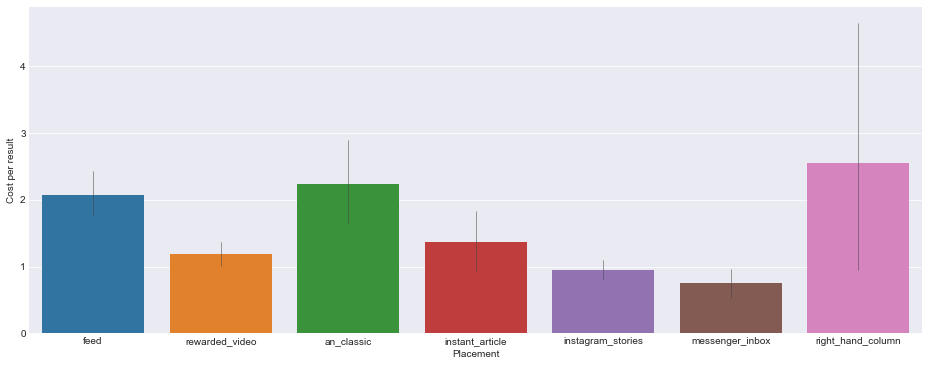

In [30]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="Cost per result", errwidth=.5, data=plac)
ha

__________

### Average CTR by placement

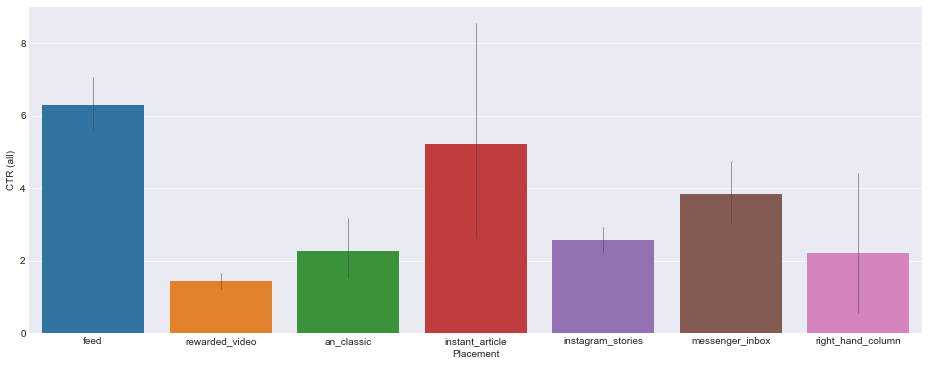

In [31]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="CTR (all)", errwidth=.5, data=plac)
ha

______________

### Average CPM by placement

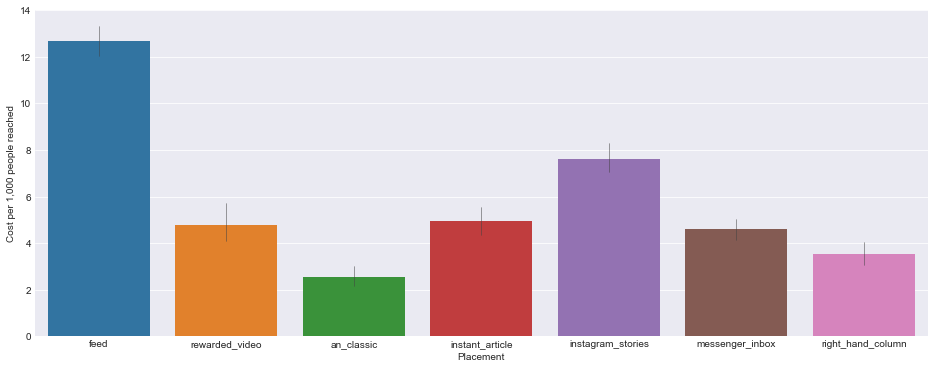

In [32]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="Cost per 1,000 people reached", errwidth=.5, data=plac)
ha

______________

### Average Frequency by Placement

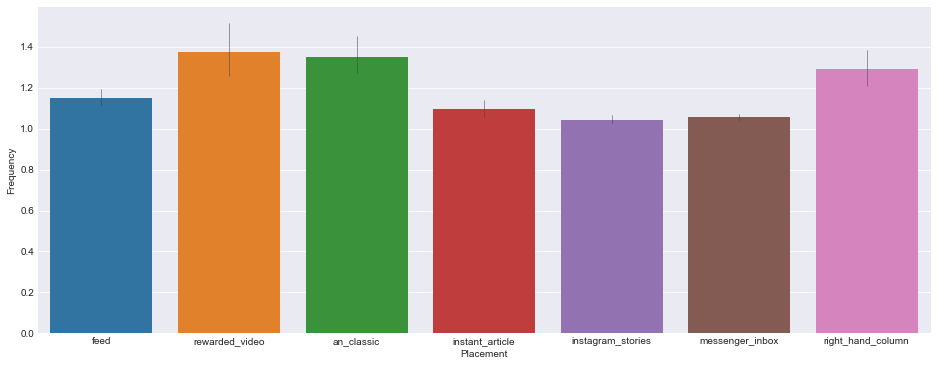

In [33]:
plt.pyplot.figure(figsize=(16,6))
ha=sns.barplot(x="Placement", y="Frequency", errwidth=.5, data=plac)
ha

_______

In [34]:
engag = pd.read_csv("bm_engag.csv")
engag["tag"] = engag['Ad set name'].str.split(',').str[0]
engag = engag.fillna(value=0)
engag.drop(columns=["Ad set name","Ad set ID","Reporting starts","Reporting ends"], inplace=True)

In [35]:
comb = pd.merge(df_asl, engag, how="right", on=["tag"])
comb = comb.dropna()

# Section 3. Combined data

### Relationship between engagement and margin

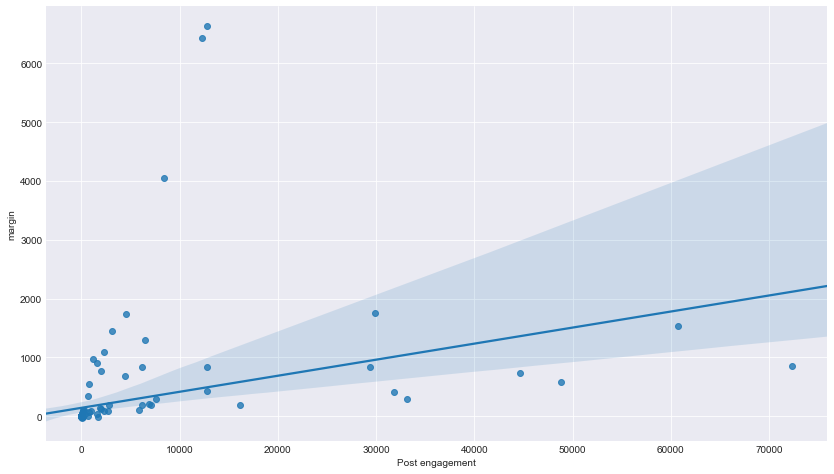

In [36]:
plt.pyplot.figure(figsize=(14,8))
sns.regplot(x="Post engagement", y="margin", data=comb.loc[comb["Post engagement"]<100000])

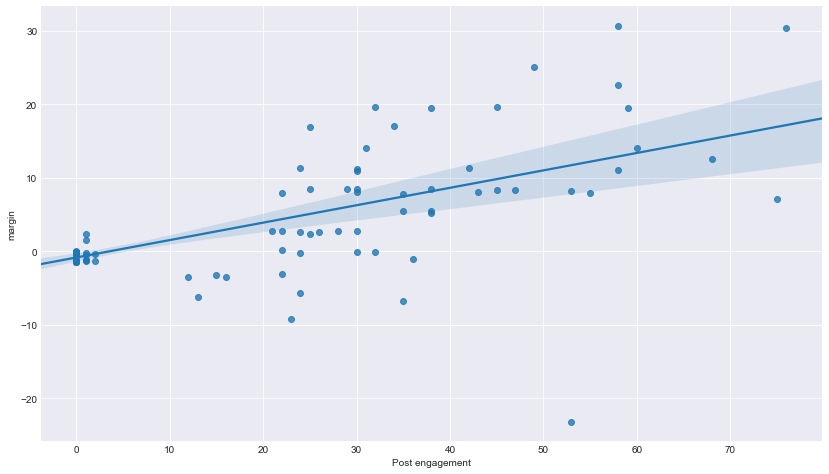

In [37]:
plt.pyplot.figure(figsize=(14,8))
sns.regplot(x="Post engagement", y="margin", data=comb.loc[comb["Post engagement"]<100])

____________

In [38]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>